### Data sources: From kaggle (publisher obtained this database from steam website)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = 'gta5_steam.csv'
df = pd.read_csv(csv_file)
print('Column name:', df.columns)


Column name: Index(['id', 'language', 'review', 'created', 'voted_up', 'votes_up',
       'comment_count', 'steam_purchase', 'recieved_for_free',
       'written_during_early_access', 'author_num_games_owned',
       'author_num_reviews', 'author_playtime_forever',
       'author_playtime_last_two_weeks', 'author_playtime_at_review',
       'author_last_played'],
      dtype='object')


### Drop outliers and some columns do not need to consider

In [14]:
# find the outlier(from gta5 publish date to the date this data been recorded)
outlier = df[df['author_playtime_forever']>10000] #8 years and 9 month(if over -> unreasonable)
print(outlier.shape)

# drop the outliers and some columns do not need
new_df = df.drop(df[df['author_playtime_forever']>10000].index)
new_df = new_df.reset_index(drop = True)
new_df = new_df.drop(['votes_up','comment_count','language'],axis=1)
print(new_df.columns)


(15180, 16)
Index(['id', 'review', 'created', 'voted_up', 'steam_purchase',
       'recieved_for_free', 'written_during_early_access',
       'author_num_games_owned', 'author_num_reviews',
       'author_playtime_forever', 'author_playtime_last_two_weeks',
       'author_playtime_at_review', 'author_last_played'],
      dtype='object')


In [15]:
import numpy as np
# print(new_df['review'])

# Strip leading and trailing whitespace, then replace empty strings with NaN
new_df['review'] = new_df['review'].str.strip().replace(['', None], np.nan)
new_df = new_df.rename(columns={'review':'comments'})
new_df = new_df.dropna(subset='comments')
# print(new_df['review'].iloc[30])
# print(new_df.iloc[30,:])
new_df = new_df.reset_index(drop = True)
new_df.head(5)


,id,comments,created,voted_up,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,157337410,"Games good, But Rockstar Your a BILLION DOLLAR...",2024-02-01 16:00:22,True,True,False,False,0,9,9105,131,9105,2024-01-30 21:04:02
1,157337371,modders make it better and free everything,2024-02-01 15:59:57,True,True,True,False,0,1,2530,1728,2530,2024-02-01 16:01:41
2,157336468,best,2024-02-01 15:47:51,True,True,False,False,34,3,2842,431,2816,2024-02-01 15:50:12
3,157335380,sed,2024-02-01 15:32:26,True,True,False,False,11,2,2055,79,2021,2024-02-01 16:12:38
4,157335196,old but good,2024-02-01 15:29:28,True,True,False,False,8,4,702,702,669,2024-02-01 16:14:19


### Transform reviews to sentiment score

In [16]:
# create sentiment score
from nltk.sentiment import SentimentIntensityAnalyzer
# Assuming you have already initialized the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply polarity_scores to each review in the 'review' column
sentiment_df = new_df['comments'].apply(lambda x: sia.polarity_scores(x))
# print(sentiment_df)
sen_score = sentiment_df.apply(lambda x : x['compound'])
new_df['sentiment_score'] = sen_score
# plt.boxplot(new_df['sentiment_score'])
# plt.xlabel('sentiment score')


## Diagram of playtime and number of reviews over time

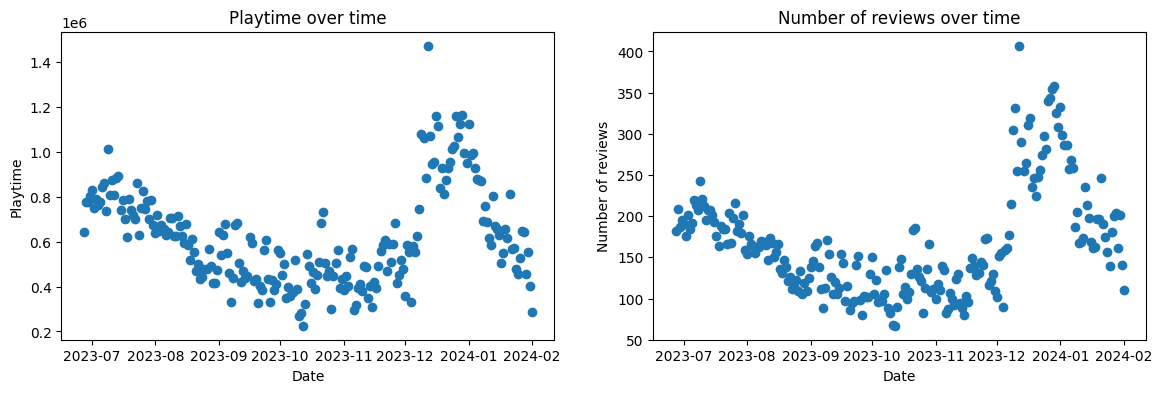

In [17]:
new_df['play_after_review'] = new_df['author_playtime_forever'] - new_df['author_playtime_at_review']
# new_df['sentiment_score'].corr(new_df['play_after_review'])
# plt.scatter()
# new_df['created'].dtype
# new_df['created']
new_df['created'] = pd.to_datetime(new_df['created'])
new_df = new_df.sort_values(by='created')
new_df = new_df.reset_index(drop=True)
# plt.scatter(new_df['created'])

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
time = new_df['created']
play_time = new_df['author_playtime_forever']
date = time.dt.date
play_counts = pd.DataFrame(zip(date, play_time), columns=['date', 'play_time'])
counts = play_counts.groupby('date')['play_time'].sum()
counts_df = counts.reset_index()
counts_df['date'] = pd.to_datetime(counts_df['date'])
ax[0].scatter(counts_df['date'],counts_df['play_time'])
ax[0].set_title('Playtime over time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Playtime')
counts_per_date = play_counts.groupby('date').size()
ax[1].scatter(counts_per_date.index, counts_per_date.values)
ax[1].set_title('Number of reviews over time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of reviews')
plt.show()

# print(new_df.head(3))
# print(new_df['steam_purchase'].value_counts())
# print(new_df['recieved_for_free'].value_counts())
# print(new_df[(new_df['steam_purchase'] == True) & (new_df['recieved_for_free'] == True)])
# print(new_df[(new_df['steam_purchase'] == False) & (new_df['recieved_for_free'] == True)])
# print(new_df[(new_df['steam_purchase'] == False) & (new_df['recieved_for_free'] == False)])
# print(new_df[(new_df['steam_purchase'] == True) & (new_df['recieved_for_free'] == False)].head(3))


### Speculation:
### 1. From the playhour plot above, there is an increase in playing time and number of review in July and January, suggesting some seasonality in the data. I speculate this could be because these months coincide with student vacation periods.
### 2. Based on the previous observation, it can be inferred that students may be the primary group influencing the GTA5 game market.
### 3. The promotions on Steam in July and January appear to stimulate purchasing activity.

## Wordcloud of negative score 

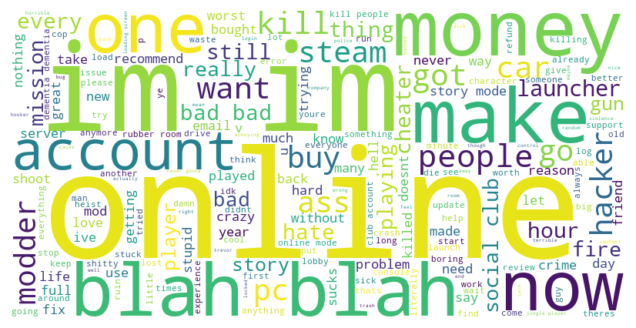

In [18]:
from wordcloud import WordCloud
import re
## negative comments
neg_score_new_df = new_df[new_df['sentiment_score'] < 0]
# List of sensitive words to filter
sensitive_words = ["game", "rockstar", "niggers", "fuck","fucking",  "shit", "play", "gta", "good" , "will" , "cant"
, "fun", "time", "even", "dont", 'racistniggers', "games", "suck"]

# Sample DataFrame
# Assuming neg_score_new_df['comments'] contains the comments
comments = [review for review in neg_score_new_df['comments'] if isinstance(review, str)]

# Combine all reviews into a single string
text = " ".join(comments)

# Preprocess text: Remove special characters and lowercase
text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

# Remove sensitive words
pattern = r'\b(' + '|'.join(sensitive_words) + r')\b'  # Create a regex pattern for sensitive words
filtered_text = re.sub(pattern, '', text)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(filtered_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# # Split text into sentences and count their frequencies
# all_sentences = [sentence.strip() for review in neg_score_new_df['comments'] for sentence in review.split('.')]
# sentence_counts = Counter(all_sentences)

# # Display most common sentences
# print(sentence_counts.most_common(10))  # Top 10 most common sentences


### From the word cloud above, I identified several meaningful words, such as "online mode", "modder", "hacker" and "account issues," which might be the main concerns for players who left negative comments.

## Wordcloud of positive score 

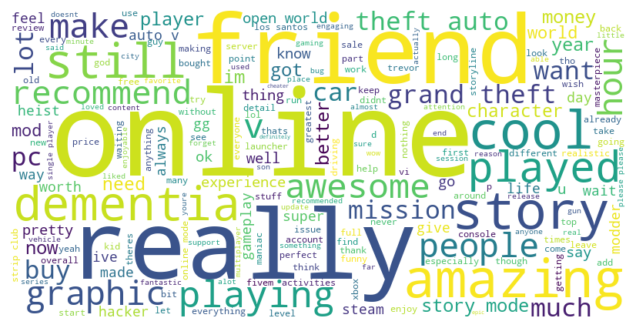

In [19]:
## positive comments
neg_score_new_df = new_df[new_df['sentiment_score'] > 0]
# List of sensitive words to filter
sensitive_words = ["game", "rockstar", "niggers", "fuck","fucking",  "shit", "play", "gta", "good" , "will" , "cant"
, "fun", "time", "even", "dont", 'racistniggers', "games", "suck", 'best', 'great', "nice", "love", "ye", "yes", "one"]

# Sample DataFrame
# Assuming neg_score_new_df['comments'] contains the comments
comments = [review for review in neg_score_new_df['comments'] if isinstance(review, str)]

# Combine all reviews into a single string
text = " ".join(comments)

# Preprocess text: Remove special characters and lowercase
text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

# Remove sensitive words
pattern = r'\b(' + '|'.join(sensitive_words) + r')\b'  # Create a regex pattern for sensitive words
filtered_text = re.sub(pattern, '', text)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(filtered_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### From the word cloud above, I identified several meaningful words and speculated on their meaning, such as "playing with friends", "online mode", "storyline" and "graphics", which might be the main characteristics for players who left positive comments.

## See the rate of playing time after review

In [20]:
rate_play_after_review = len(new_df[new_df['author_playtime_forever'] <= new_df['author_playtime_at_review']]) / len(new_df[new_df['author_playtime_forever'] > new_df['author_playtime_at_review']])
print(f'Rate of player still playing after review: {(1-rate_play_after_review)*100:.2f}%')

Rate of player still playing after review: 90.69%


In [21]:
filtered_neg_df = new_df[
    (new_df['author_playtime_forever'] <= new_df['author_playtime_at_review']) &
    (new_df['sentiment_score'] < 0)
]
filtered_pos_df = new_df[
    (new_df['author_playtime_forever'] > new_df['author_playtime_at_review']) &
    (new_df['sentiment_score'] >= 0)
]
# filtered_df.shape

print(f'negative review but keep playing: {1-(len(filtered_neg_df) / len(new_df[new_df['author_playtime_forever'] <= new_df['author_playtime_at_review']])):.2f}')
print(f'positive review and keep playing: {len(filtered_pos_df) / len(new_df[new_df['author_playtime_forever'] > new_df['author_playtime_at_review']]):.2f}')

negative review but keep playing: 0.81
positive review and keep playing: 0.90


### The results show that most players continue to engage with the game, regardless of whether they left a negative or positive review. This suggests that the game is still beloved by players and continues to grow, with 81% of players leaving negative comments and 90% of players leaving positive comments indicating they would keep playing the game after leaving their feedback.

In [22]:
print('total mean sentiment score: ', np.mean(new_df['sentiment_score']))

senior_player = new_df[new_df['author_playtime_forever'] > 500]
print('mean sentiment score of senior players: ', np.mean(senior_player['sentiment_score']))

novice_player = new_df[new_df['author_playtime_forever'] <= 500]
print('mean sentiment score of novice players: ', np.mean(novice_player['sentiment_score']))


total mean sentiment score:  0.2546413729178594
mean sentiment score of senior players:  0.259037244165959
mean sentiment score of novice players:  0.19525363924050634


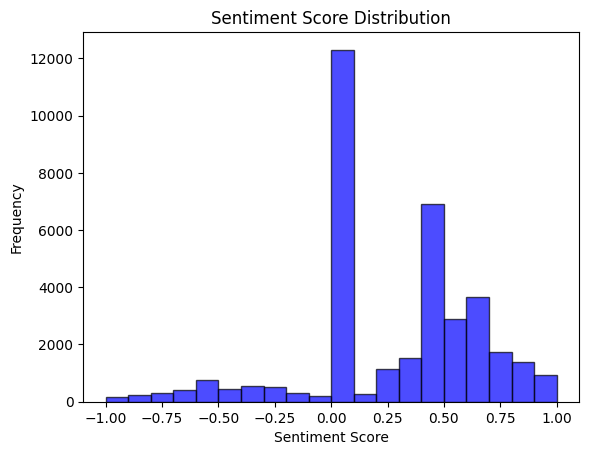

In [23]:
import matplotlib.pyplot as plt

# Plot distribution
plt.hist(new_df['sentiment_score'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')
plt.show()

In [24]:
# print(new_df['voted_up'].value_counts())
comment_voted_up = new_df[new_df['voted_up'] == True]
print('average sentiment score for comments been voted up',np.mean(comment_voted_up['sentiment_score']))


average sentiment score for comments been voted up 0.2900242129602182


### The comments that received upvotes were selected, indicating that these comments hold greater reference value. The average sentiment score for upvoted comments is higher than the overall average sentiment score. Typically, algorithms prioritize highly upvoted comments, placing them at the top of the comment section, which increases their visibility to more players. This pattern also suggests that the game is heading in a favorable direction.